In [1]:
# import dill
import numpy as np
from matplotlib import figure, gridspec,colors
# from pathlib import Path
# from astropy.table import Table
# from astropy import units as u
# from astropy.coordinates import SkyCoord

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
from astropy import visualization as vis



bands = ["u_5_15", "u_15_25", "u_25_35", "u_35_45", "u_45_55", "u_55_65", "u_65_75", "u_75_90", "l_15_5", "l_25_15", "l_35_25", "l_45_35", "l_55_45", "l_65_55", "l_75_65", "l_90_75", "center"]
versions = ["hess1","hess1u"]
paths = [f"/lustre/fs22/group/hess/user/wybouwt/full_scanner_survey/{version}/{band}" for band in bands for version in versions]
# mplets = scani.Multiplets(paths[0])
# mplets.appendMultiplets(*[scani.Multiplets(path) for path in paths[1:]])
mplet_list = [scani.Multiplets(path) for path in paths]


unicorns = [9,18]
for j in unicorns:
    mplet_list[j].objectifyColumns()

    
mplets = mplet_list[0]
mplets.appendMultiplets(*mplet_list[1:])

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 6.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 0.000e+00,
        6.000e+00, 4.000e+00, 3.000e+0

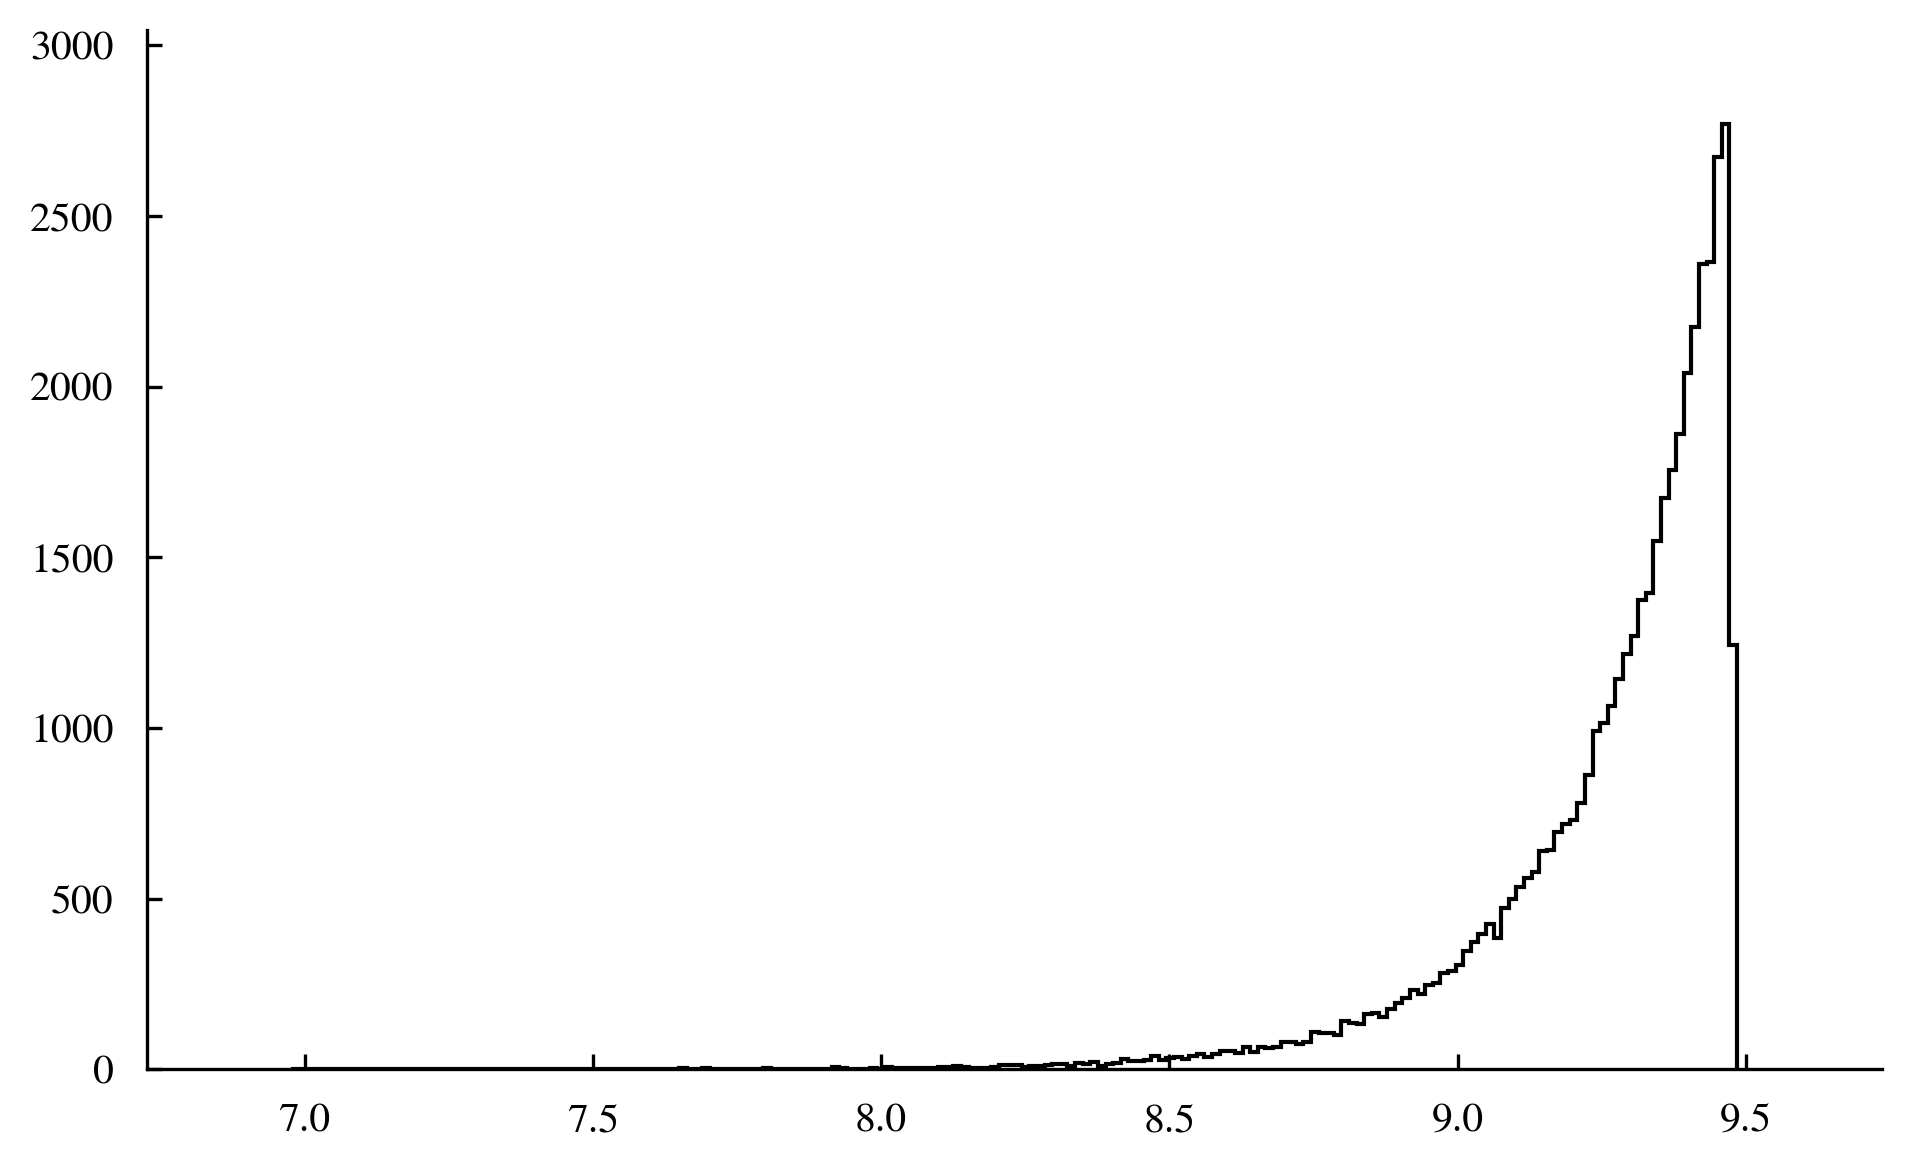

In [15]:
vis.hist(np.log10(mplets.table["dt"]),bins="freedman",histtype="step")

Masking of probably background events

In [2]:
# arbitrarily determined from figure...
a = 1e8
b = 75e-3

@np.vectorize
def recip(x,a=a,b=b):
    return a/x + b
dt_da_mask = mplets.table["da"] <= recip(mplets.table["dt"])
print(f"fraction kept after high da-dt cut: {round(sum(dt_da_mask)/len(mplets),2)}")

fraction kept after high da-dt cut: 0.25


dt_da mask plot

In [3]:
fig = figure.Figure()
ax = fig.add_subplot()
hist = ax.hist2d(mplets.table["dt"],mplets.table["da"])
fig.colorbar(hist[3],ax=ax)
DT = np.linspace(min(mplets.table["dt"]),max(mplets.table["dt"]),int(1e4))
ax.plot(DT,recip(DT),color="red",ls="--")
ax.set_xlabel("dt [ns]")
ax.set_ylabel("da [deg]")
fig.set_size_inches(6,5)
ax.set_title("dt-da historam with proposed background cut")

fig.savefig("figures/tests/dt_da_cut.png",facecolor="white")

Aitov scatter

In [ ]:
fig,ax = mplets.getAitoffFigure()
fig.savefig("figures/combined/aitoff.png",facecolor="white",dpi=300)

Cornerplot of the resulting multiplets

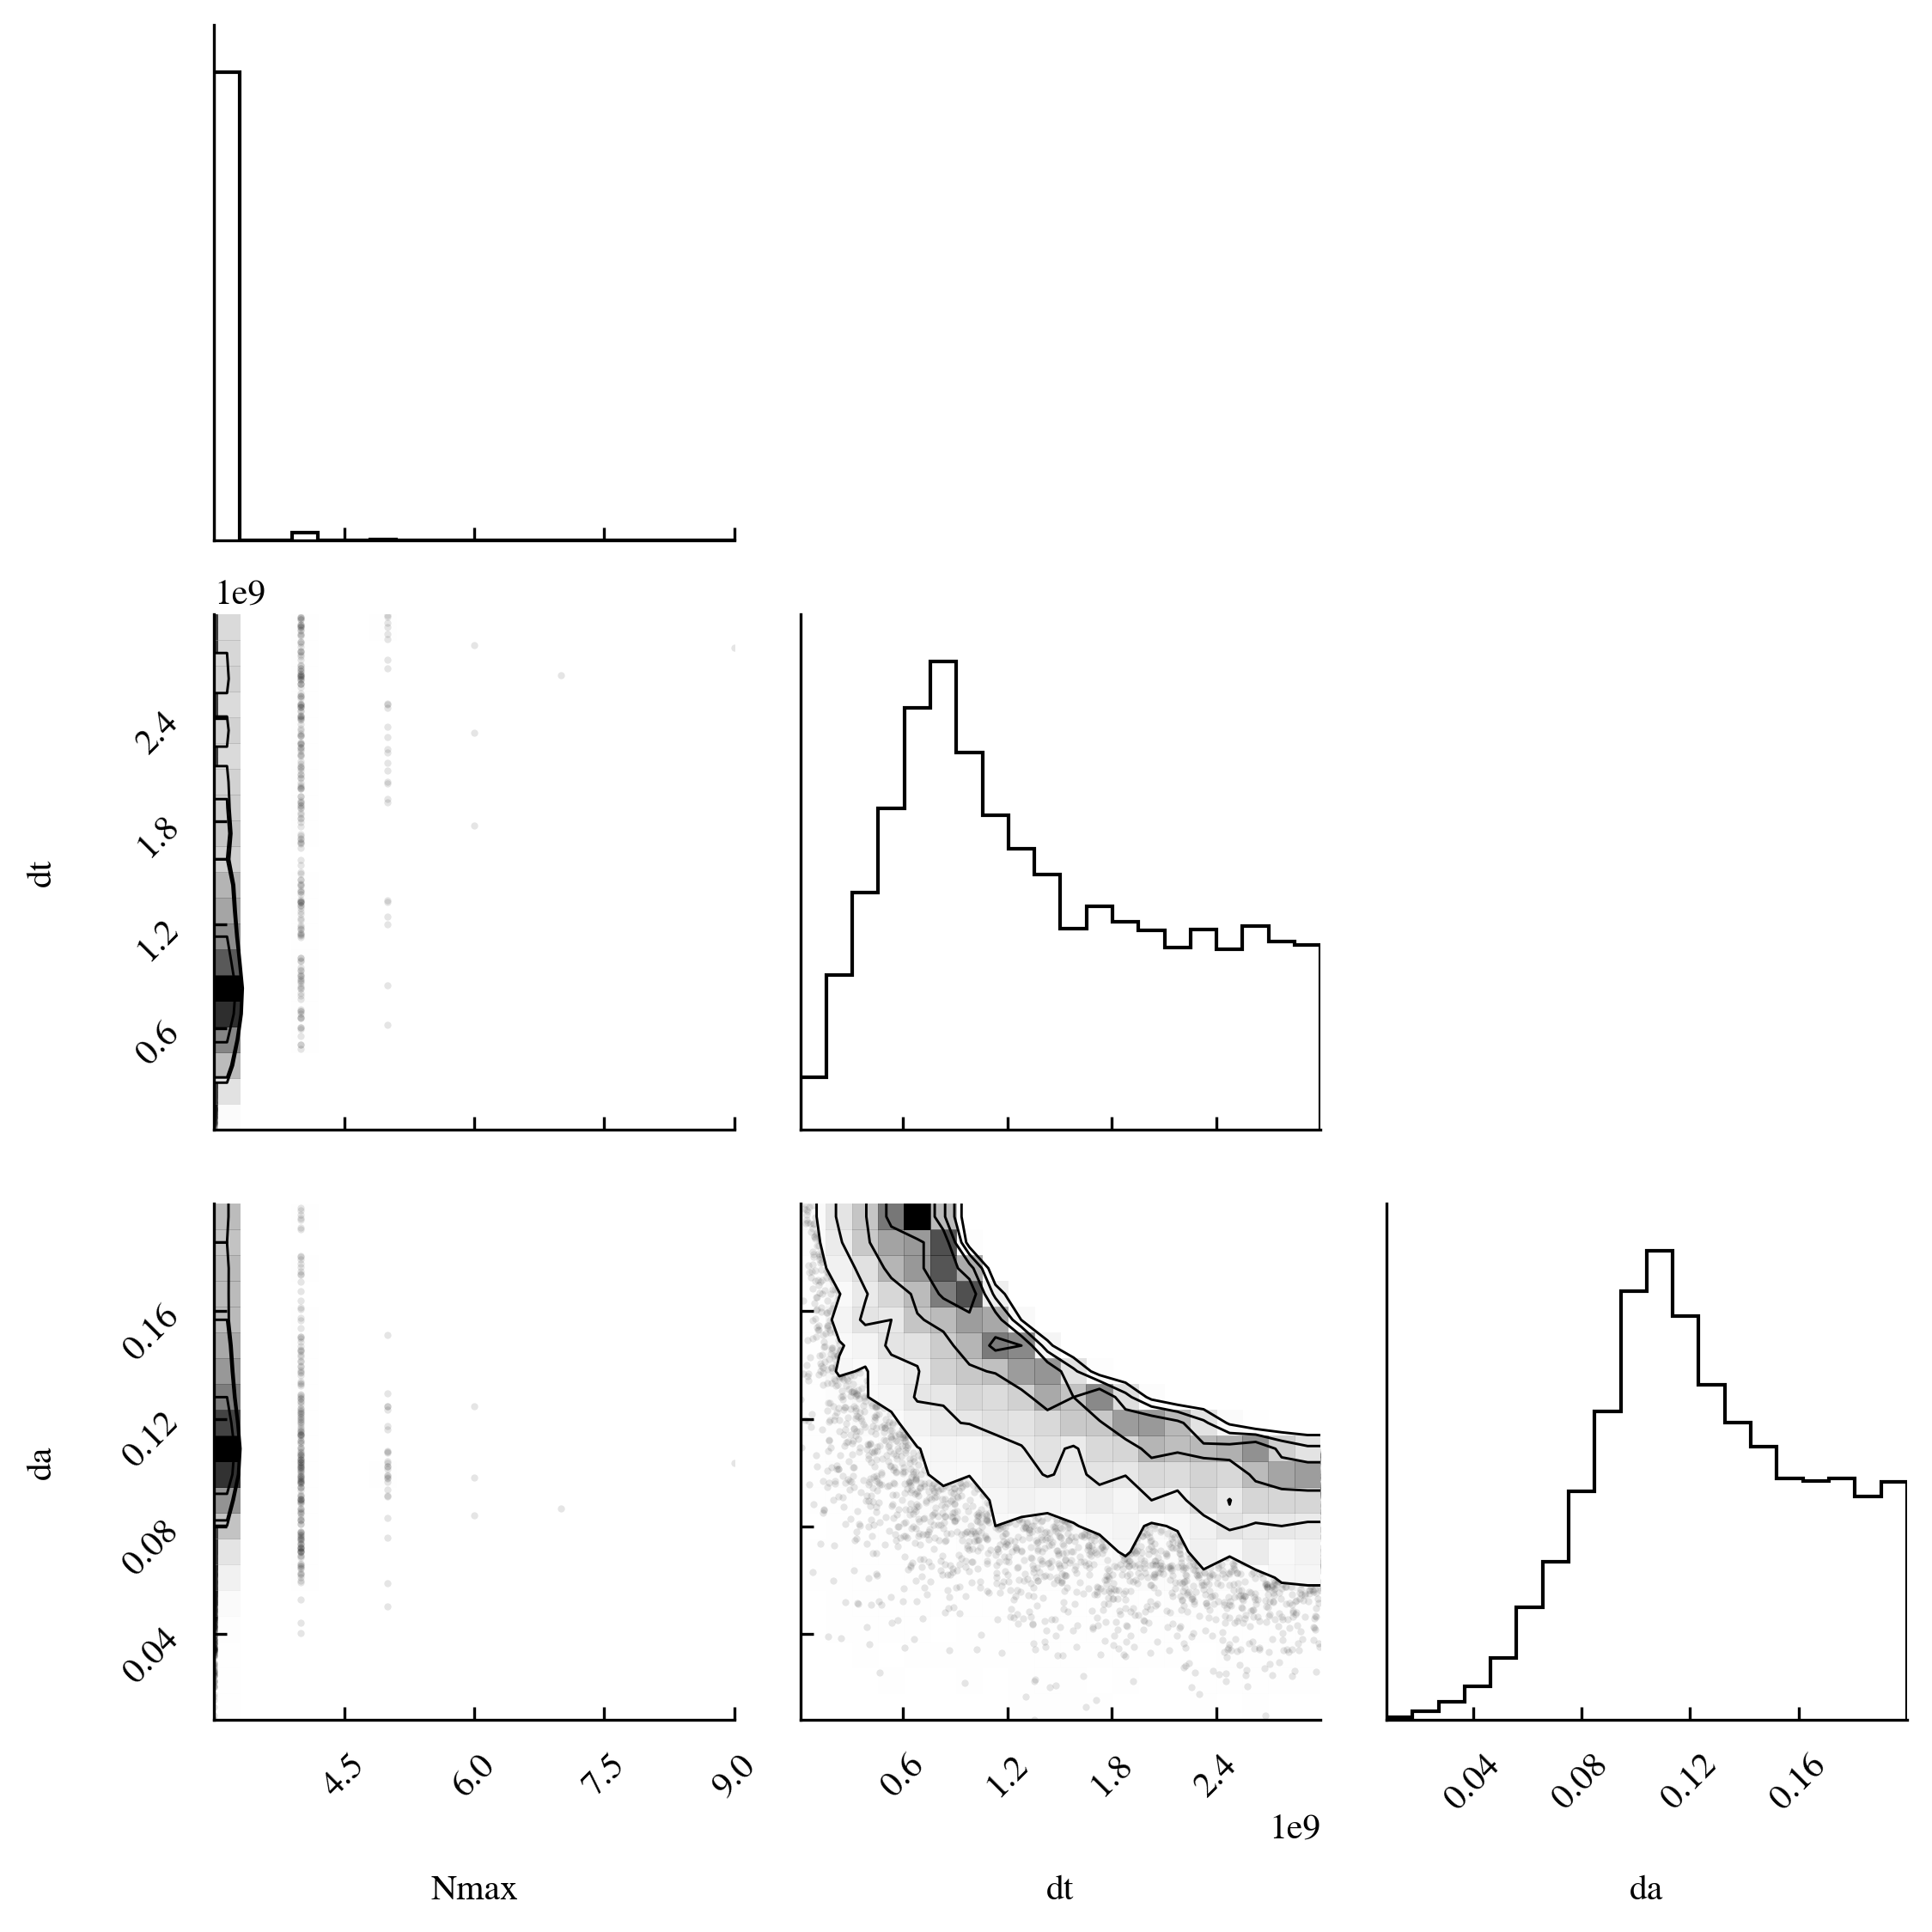

In [4]:
# plotting mplet results
from corner import corner

fig = corner(mplets.table[dt_da_mask].to_pandas(),var_names=["Nmax","dt","da"])
# fig.savefig("figures/combined/corner_center.png",facecolor="white",dpi=300)

TeVCat search and distance histogram

In [7]:
from tevcat import TeVCat
tevcat = TeVCat()
mplets.searchTeVCat(tevcat.sources)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2

fmask = dt_da_mask * nosource_mask

Unknown observatory name found in GRB 160821B:  None
Unknown "discoverer" ID found in GRB 160821B: None
Unknown observatory name found in SNR G004.8+6.2:  None
Unknown "discoverer" ID found in SNR G004.8+6.2: None
Unknown observatory name found in 3HWC J0621+382:  None
Unknown "discoverer" ID found in 3HWC J0621+382: None
Unknown observatory name found in 3HWC J0630+186:  None
Unknown "discoverer" ID found in 3HWC J0630+186: None
Unknown observatory name found in 3HWC J0631+107:  None
Unknown "discoverer" ID found in 3HWC J0631+107: None


In [ ]:
current_mask = fmask

vline_sourcebound = .2
hist = vis.hist(mplets.table[current_mask]["TEVCAT_DISTANCES_DEG"],bins="freedman",histtype="step",stacked=True)
ax = plt.gca()
ax.set_xlabel("Distance to nearest TeVCat source [deg]")
ax.set_ylabel("Counts")
ylim = ax.get_ylim()
ax.vlines(vline_sourcebound,0,ylim[1],color="red",ls="--",label=f"{vline_sourcebound} deg")
ax.set_ylim(*ylim)
# ax.set_yscale("log")
ax.set_xlim(0,15)
ax.legend()
# ax.set_xscale("log")
# plt.savefig("figures/combined/sourcedist_hist.png",facecolor="white")

HEALPix

In [ ]:
cmap = cm.plasma
cmap.set_under("white")
m = scani.cat2hpx(mplets.table[fmask]["MEDIAN_RA"],mplets.table[fmask]["MEDIAN_DEC"],nside=2**7)
hp.mollview(m,cmap=cmap)
ax = plt.gca()
ax.images[0].set_norm(colors.PowerNorm(.2))
# plt.savefig("figures/combined/healpy.png",facecolor="white")

Nmax histogram

Nmax left after mask: 9


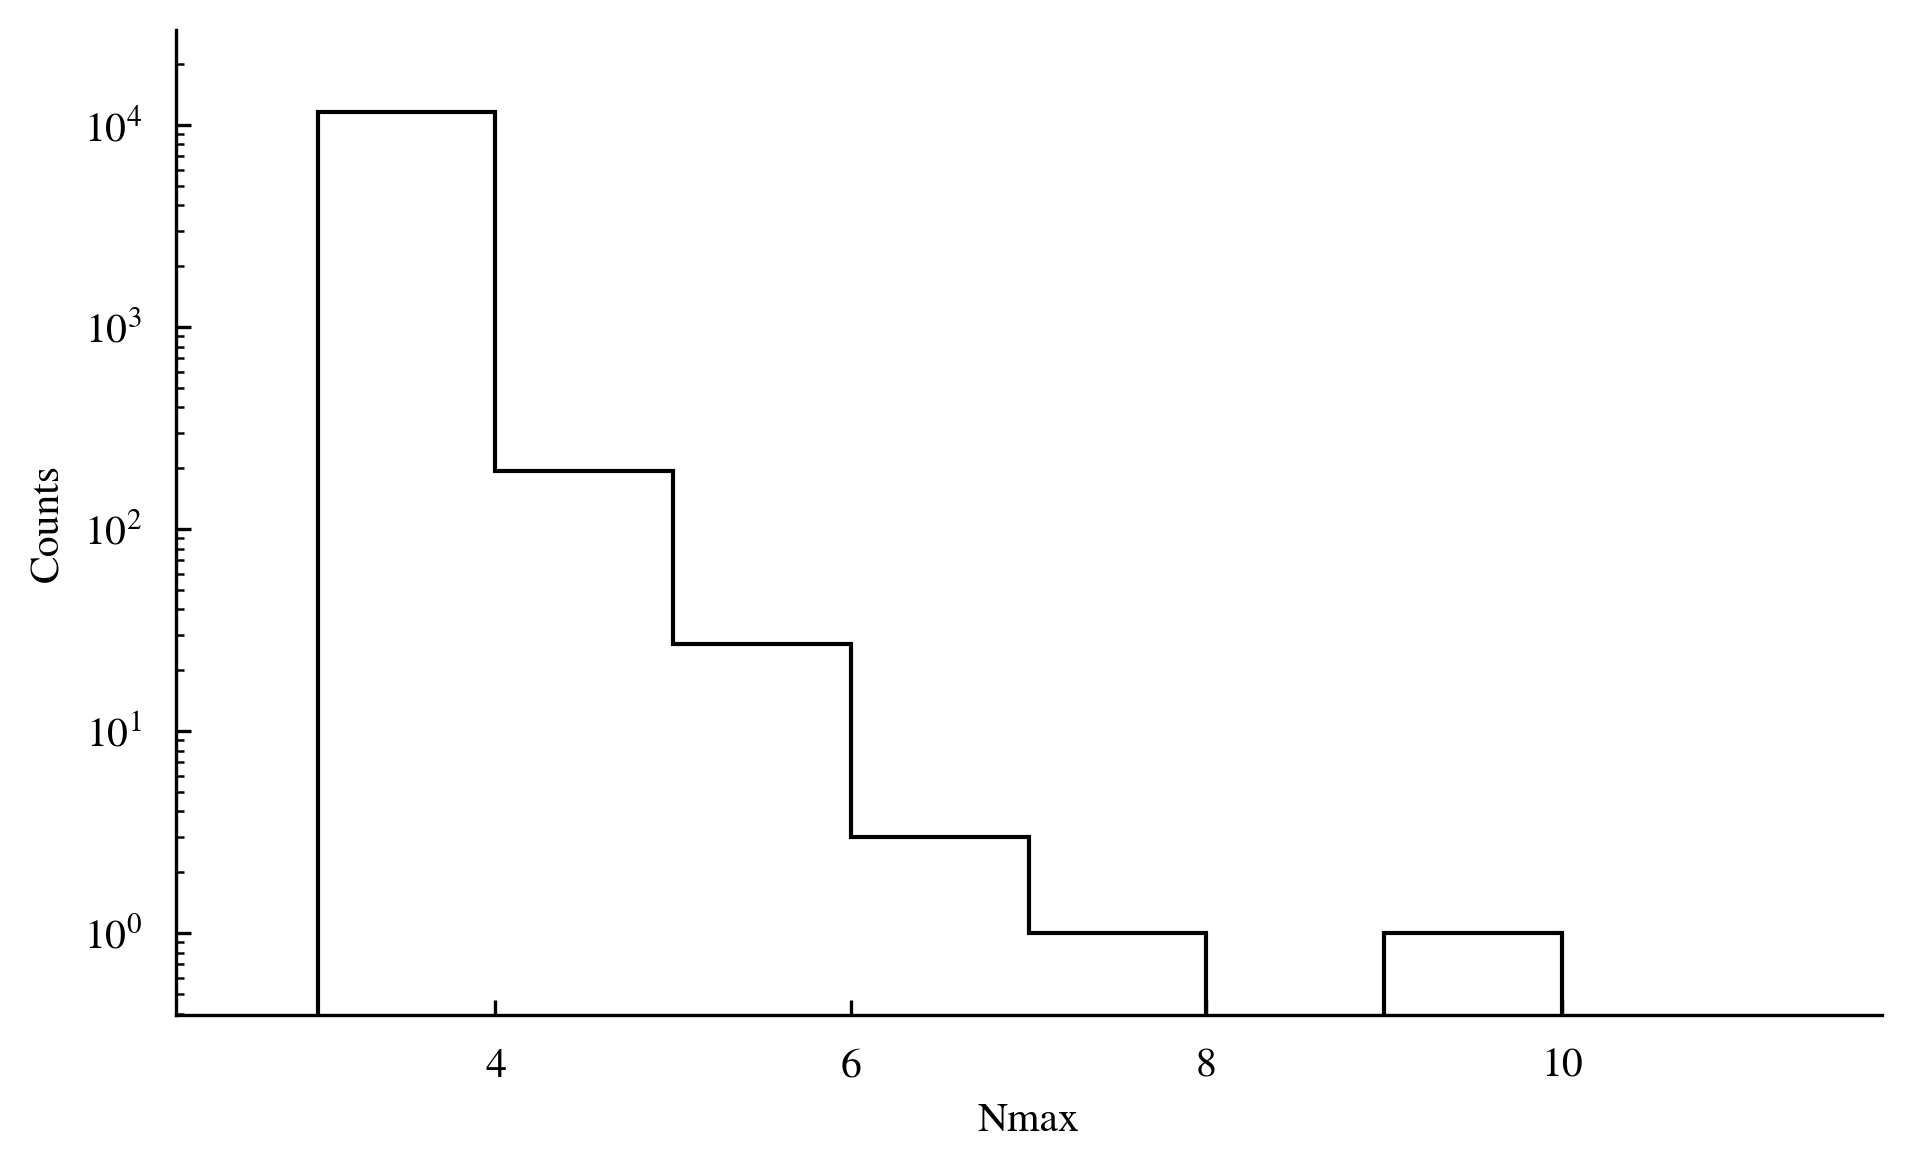

In [8]:
current_mask = dt_da_mask

remaining_Nmax = max(mplets.table[current_mask]["Nmax"])
print(f"Nmax left after mask: {remaining_Nmax}")
hist = vis.hist(mplets.table[current_mask]["Nmax"],bins=range(3,remaining_Nmax+3),histtype="step")
ax = plt.gca()
ax.set_xlabel("Nmax")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# ax.set_xticks(range(3,22))
# plt.savefig("figures/combined/Nmax_hist.png",facecolor="white")

In [12]:
current_mask = dt_da_mask * mplets.table["Nmax"] > 3
mplets.table.sort("Nmax")
mplets.table[current_mask]["Nmax","OBS_ID","dt","da","MEDIAN_GLAT","TEVCAT_SOURCE_NAME","TEVCAT_SOURCE_TYPE","TEVCAT_DISTANCES_DEG"]

Nmax,OBS_ID,dt,da,MEDIAN_GLAT,TEVCAT_SOURCE_NAME,TEVCAT_SOURCE_TYPE,TEVCAT_DISTANCES_DEG
int64,uint32,float64,float64,float64,str21,str22,float64
4,147846,2311864576.0,0.1654873755034973,-0.15712303623874094,Galactic Centre,UNID,0.605711115192071
4,23593,2085831680.0,0.1639729985600115,-5.760444427353739,Crab Pulsar,PSR,0.029768151102621532
4,23546,1142414336.0,0.16148168256699344,-5.744132304614329,Crab Pulsar,PSR,0.06471337788199176
4,25548,2712821632.0,0.19600011426136302,-0.706879228781086,HESS J1825-137,PWN/TeV Halo,0.61855793784831
4,131379,2712785408.0,0.14037396363333773,3.711148541878699,HESS J1741-302,UNID,4.016505118323855
4,18923,2853657472.0,0.14427328789860958,-5.749174282275178,Crab Pulsar,PSR,0.07100220784115621
4,42882,1047503616.0,0.18980762846958518,-88.66882057780981,NGC 253,Starburst,0.7992092053341479
4,80163,2926740224.0,0.10228996197971511,-5.765369647545568,Crab Pulsar,PSR,0.02144941454226137
4,139390,2790556672.0,0.163710089181818,57.53397953406676,3C 279,FSRQ,1.55319589738878
